##  pretrained models in PyTorch

This notebook only has the default pyTorch models

- VGG and VGG BN 
- We only want the initial Conv layers since we know how the  larger layers behave

In [3]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn

import pandas as pd

import numpy as np
import powerlaw

from tqdm import tqdm_notebook as tqdm

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5,5]
matplotlib.rcParams.update({'font.size': 16})

In [5]:
MIN_DIM = 50

### All Linear Models

In [6]:
def get_conv2D_Wmats(Wtensor):
    """Extract W slices from a 4 index conv2D tensor of shape: (N,M,i,j) or (M,N,i,j).  Return ij (N x M) matrices"""
    Wmats = []
    s = Wtensor.shape
    N, M, imax, jmax = s[0],s[1],s[2],s[3]
    #print("tensor shape", N,M,imax,jmax)
    for i in range(imax):
        for j in range(jmax):
            W = Wtensor[:,:,i,j]
            if N < M:
                W = W.T
            Wmats.append(W)
    return Wmats

In [7]:
def count_layers(model):
    """Loops over a pytorch model and counts all the weight matrices, linear, conv2d, and conv2d-slices"""
    num_linear, num_conv2d, num_conv2d_slices = 0, 0, 0
    
    for im, m in enumerate(model.modules()):
        #print(im,m)
        if isinstance(m, nn.Linear):    
            #print("linear")
            W = np.array(m.weight.data.clone().cpu())
            if W is not None:
                #print(im,m, W.shape)
                num_linear += 1
        elif isinstance(m, nn.Conv2d):
            #print("conv2d")
            Wtensor = np.array(m.weight.data.clone().cpu())
            #print(Wtensor.shape)
            Wmats = get_conv2D_Wmats(Wtensor)
            #print(im,m)
            num_conv2d += 1
            for W in Wmats:
                #print(W.shape)
                if (np.min(W.shape) >= MIN_DIM):
                    num_conv2d_slices += 1
                
    return num_linear, num_conv2d, num_conv2d_slices
        

In [8]:
def iter_pytotch_layers(model, min_dim=MIN_DIM):
    """Iterate over a pytorch layers and  weight matrix.  
    Supports linear, conv2d, and conv2d-slices"""
    for im, m in enumerate(model.modules()):
        if isinstance(m, nn.Linear):     
            W = np.array(m.weight.data.clone().cpu())
            if W is not None:
                yield W
        elif isinstance(m, nn.Conv2d):
            Wtensor = np.array(m.weight.data.clone().cpu())
            Wmats = get_conv2D_Wmats(Wtensor)
            for W in Wmats:
                if (np.min(W.shape) >= min_dim):
                    yield W

In [9]:
def calc_model_alphas(model):
    try:
        alphas, norms, lmaxs = [], [], []

        for W in tqdm(iter_pytotch_layers(model)):
            M, N = W.shape[0], W.shape[1]
            print(M,N)
            if M > 1024:
                break
                
           # correct for glorot normalization
            glorot_correction = np.sqrt(np.average(W.shape))
            W = W*glorot_correction
            normW = np.linalg.norm(W)

            if (M>N):
                X=np.dot(W.T,W)/N
            else:
                X=np.dot(W,W.T)/N

            evals = np.linalg.eigvals(X)
            
            l_max = np.max(evals)
            if (l_max > 1):
  
                fit = powerlaw.Fit(evals, xmax=l_max, verbose=False)
               

                print(N, M, X.shape, fit.alpha, np.max(evals), fit.D)

                alphas.append(fit.alpha)
                norms.append(normW)
                lmaxs.append(l_max)
            
           
    except Exception as e: 

        print("skipping ", model_name)
        print(e)

        pass
    
    return  np.array(alphas),  np.array(norms), np.array(lmaxs)

In [63]:

alphas, norms, lmaxs = {}, {}, {}


model_name = 'vgg11'
model = models.vgg11(pretrained=True)
alphas[model_name], norms[model_name], lmaxs[model_name]  =  calc_model_alphas(model)


model_name = 'vgg13'
model = models.vgg13(pretrained=True)
alphas[model_name], norms[model_name], lmaxs[model_name]  =  calc_model_alphas(model)


model_name = 'vgg16'
model = models.vgg16(pretrained=True)
alphas[model_name], norms[model_name], lmaxs[model_name]  =  calc_model_alphas(model)

model_name = 'vgg19'
model = models.vgg19(pretrained=True)
alphas[model_name], norms[model_name], lmaxs[model_name] =  calc_model_alphas(model)



128 64
64 128 (64, 64) 1.6501380557141414 6.738295 0.1694855053362465
128 64
64 128 (64, 64) 1.5729749512187854 8.271922 0.1797384350918581
128 64


/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


64 128 (64, 64) 1.4121035942309466 6.4598393 0.19428117596452105
128 64
64 128 (64, 64) 1.4345913109436141 6.8347855 0.18133933322787987
128 64
64 128 (64, 64) 1.6184989159677603 13.821855 0.16232586138055982
128 64
64 128 (64, 64) 1.3854852949105274 8.080619 0.18905146934229966
128 64
64 128 (64, 64) 1.569204110777663 5.6521955 0.1819836181454877
128 64
64 128 (64, 64) 1.4466121577534141 7.4524913 0.18158004314008436
128 64
64 128 (64, 64) 1.6136188055006313 6.271439 0.17297128682994922
256 128
128 256 (128, 128) 2.6822107696456925 3.8933222 0.15839166995063148
256 128
128 256 (128, 128) 1.6245755183676356 6.0587945 0.15038343403592247
256 128
128 256 (128, 128) 1.7481681533160724 3.8148115 0.15976226159856022
256 128
128 256 (128, 128) 2.576076637045816 6.5674796 0.13313312865838484
256 128
128 256 (128, 128) 2.53372629580107 11.5017805 0.1260402015887302
256 128
128 256 (128, 128) 1.615083227571029 6.9235363 0.12912552961625856
256 128
128 256 (128, 128) 1.6649286743131322 3.616818 

/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:1160: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


256 256 (256, 256) 2.025263614368387 3.2093854 0.12252819152531846
256 256
256 256 (256, 256) 2.048447913043735 2.502136 0.12204158382166175
256 256
256 256 (256, 256) 2.658269352938596 3.1404648 0.12169916242995937
256 256
256 256 (256, 256) 1.80045362839399 5.752889 0.11590080291933835
256 256
256 256 (256, 256) 2.042517458656814 3.498113 0.12374506755489251
256 256
256 256 (256, 256) 2.6040953714076167 2.5047364 0.1242841322676077
256 256
256 256 (256, 256) 1.9744266107780324 3.1301105 0.12141228533720927
256 256
256 256 (256, 256) 2.073195547557657 2.4406357 0.1321530823826083
512 256
256 512 (256, 256) 2.651723173693334 4.4681783 0.10811342580002525
512 256
256 512 (256, 256) 2.1681144770246012 5.461192 0.1237198549105295
512 256
256 512 (256, 256) 2.689082947115983 4.4894295 0.09975517998639649
512 256
256 512 (256, 256) 2.055719116616769 6.160263 0.11025216122298409
512 256
256 512 (256, 256) 3.8241504066156065 10.704096 0.09906479789549272
512 256
256 512 (256, 256) 2.841661182

64 64
64 64 (64, 64) 1.9985712884332631 1.8433783 0.18598422179219143
64 64
64 64 (64, 64) 1.5227655339759387 2.8955903 0.15918360530739062
64 64
64 64 (64, 64) 2.136965314547669 1.9890639 0.16491800723443362
64 64
64 64 (64, 64) 1.4775761922756745 2.806978 0.1607357277400564
64 64
64 64 (64, 64) 1.5488979444861908 3.6493485 0.14938154760902123
64 64
64 64 (64, 64) 1.5522514471998385 2.5130134 0.1676523014457032
64 64
64 64 (64, 64) 1.4229916653090868 1.9675564 0.19553246299845828
64 64
64 64 (64, 64) 1.4870415918417614 2.9315708 0.1649691961105888
64 64
64 64 (64, 64) 1.4267632531460825 1.8302586 0.20325861810195966
128 64
64 128 (64, 64) 1.8107390944974115 4.111668 0.14500306011210584
128 64
64 128 (64, 64) 1.7729934951098707 5.8248873 0.14534382943605173
128 64
64 128 (64, 64) 1.8114717938224976 4.1783004 0.15762427369838505
128 64
64 128 (64, 64) 1.780424518798032 4.903387 0.15575138431642704
128 64
64 128 (64, 64) 1.7223669763223055 8.304812 0.14315039990089018
128 64
64 128 (64, 

64 64
64 64 (64, 64) 3.1424192327525495 2.135813 0.152011893460684
64 64
64 64 (64, 64) 2.6926891349341564 3.4032743 0.15347845128922
64 64
64 64 (64, 64) 1.7915682377283089 2.1713915 0.1834562325671376
64 64
64 64 (64, 64) 2.6447132527626422 3.38234 0.13734431441877099
64 64
64 64 (64, 64) 2.855384435102395 4.4910364 0.1428571428571429
64 64
64 64 (64, 64) 1.5722767816413206 2.9965973 0.15895584153245468
64 64
64 64 (64, 64) 1.5593464641096997 1.7237109 0.17842346953726085
64 64
64 64 (64, 64) 2.3832935344793365 3.5007145 0.13852603337240632
64 64
64 64 (64, 64) 3.109140182393354 1.9091358 0.17602557568744776
128 64
64 128 (64, 64) 1.7198477210666723 3.4988728 0.15490271161720504
128 64
64 128 (64, 64) 1.6920179881216164 3.7831995 0.15375673273094792
128 64
64 128 (64, 64) 1.873209410728218 3.574775 0.1472696798961871
128 64
64 128 (64, 64) 1.6454379546336495 4.6411138 0.15652972808597
128 64
64 128 (64, 64) 1.6638428801133012 7.7422385 0.14086574767768795
128 64
64 128 (64, 64) 1.735

64 64
64 64 (64, 64) 1.4433521793289068 1.8160154 0.1890977812264374
64 64
64 64 (64, 64) 1.5280309386212942 2.4917834 0.17109564236502772
64 64
64 64 (64, 64) 2.1337335068735563 1.7829849 0.19530536750668043
64 64
64 64 (64, 64) 1.5175890013603088 2.3594978 0.1768764738383043
64 64
64 64 (64, 64) 1.55642834616003 3.7638555 0.1654894070763936
64 64
64 64 (64, 64) 1.4913516230305128 2.7858684 0.1506093410793925
64 64
64 64 (64, 64) 1.4596254839888607 1.4963005 0.19951910845974075
64 64
64 64 (64, 64) 1.5392097111294105 2.7609317 0.1715947325839382
64 64
64 64 (64, 64) 1.4579005168599415 1.9795326 0.17514124658906383
128 64
64 128 (64, 64) 1.9480241969435628 3.4681005 0.13217525598260005
128 64
64 128 (64, 64) 1.7655845232945309 4.3141866 0.15214294667659456
128 64
64 128 (64, 64) 1.7468502875748086 3.5612361 0.16942900977332553
128 64
64 128 (64, 64) 1.7860986475137994 3.868253 0.15315541497543184
128 64
64 128 (64, 64) 1.7878028597307654 8.062503 0.14205528734304246
128 64
64 128 (64, 

512 512 (512, 512) 4.555807500657059 2.3817067 0.0604742389201158
512 512
512 512 (512, 512) 2.5820665199860815 2.736225 0.07642930985057839
512 512
512 512 (512, 512) 4.295837797091275 2.352348 0.06422991074368367
512 512
512 512 (512, 512) 3.21334304337633 2.2906008 0.06734103916856216
512 512
512 512 (512, 512) 3.8221260316877927 2.1474836 0.07846851947103489
512 512
512 512 (512, 512) 3.27710704482976 2.2856503 0.05493315236390367
512 512
512 512 (512, 512) 3.7559256576357054 2.8041542 0.055243665702196854
512 512
512 512 (512, 512) 4.456472239007802 3.129888 0.07544503157279409
512 512
512 512 (512, 512) 3.557590634781503 2.990066 0.0494416297859499
512 512
512 512 (512, 512) 4.145160130799843 3.008972 0.04761904761904767
512 512
512 512 (512, 512) 2.5465851385150122 3.46288 0.0638482576012645
512 512
512 512 (512, 512) 4.085356320239248 3.2701478 0.04301039457200273
512 512
512 512 (512, 512) 3.547508649859809 2.9065247 0.033863249429546105
512 512
512 512 (512, 512) 3.4139730350

In [17]:

alphas, norms, lmaxs = {}, {}, {}


   
model_name = 'vgg11_bn'
model = models.vgg11_bn(pretrained=True)
alphas[model_name], norms[model_name], lmaxs[model_name] =  calc_model_alphas(model)



model_name = 'vgg13_bn'
model = models.vgg13_bn(pretrained=True)
alphas[model_name], norms[model_name], lmaxs[model_name] =  calc_model_alphas(model)


model_name = 'vgg16_bn'
model = models.vgg16_bn(pretrained=True)
alphas[model_name], norms[model_name], lmaxs[model_name] =  calc_model_alphas(model)


model_name = 'vgg19_bn'
model = models.vgg19_bn(pretrained=True)
alphas[model_name], norms[model_name], lmaxs[model_name] =  calc_model_alphas(model)



128 64
64 128 (64, 64) 1.6496955282104455 3.4403384 0.2062696035013719
128 64
64 128 (64, 64) 1.5135117597221512 (5.114818+0j) 0.23009822969000904
128 64


/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  self.xmax = float(self.xmax)


64 128 (64, 64) 1.6653278881632256 3.427748 0.2209022207924561
128 64
64 128 (64, 64) 1.7353058922987887 5.5120263 0.22664930575535136
128 64
64 128 (64, 64) 1.3312674606669561 (8.876278+0j) 0.23262004629082683
128 64
64 128 (64, 64) 1.3956645842157382 4.4487815 0.24556456930988768
128 64
64 128 (64, 64) 1.7195690653132751 3.6520295 0.18926275927547415
128 64
64 128 (64, 64) 1.8362425274909522 (5.4406705+0j) 0.22276691644336188
128 64
64 128 (64, 64) 2.1316335542455898 3.4761503 0.24408105950538184
256 128
128 256 (128, 128) 2.238046386742602 4.2585163 0.10909776663041992
256 128
128 256 (128, 128) 1.756387857119497 4.508242 0.13504894700321934
256 128
128 256 (128, 128) 2.229832597743782 4.4788394 0.09628645314303619
256 128
128 256 (128, 128) 1.9745367174822737 4.381457 0.1372015280407538
256 128
128 256 (128, 128) 2.8687639961977567 7.616826 0.11077821949100752
256 128
128 256 (128, 128) 1.6140793843841346 4.1072206 0.1406623568443336
256 128
128 256 (128, 128) 2.024799553284514 3.9

/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:1160: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


256 256 (256, 256) 2.109953041505934 1.496708 0.14019921668944613
256 256
256 256 (256, 256) 2.0354392031924347 1.925987 0.12974866755032494
256 256
256 256 (256, 256) 2.258426826746946 1.534066 0.1295025886015907
256 256
256 256 (256, 256) 1.8870314866924645 1.7615947 0.14037357706003128
256 256
256 256 (256, 256) 4.4268003000727045 3.2718396 0.12898237158256232
256 256
256 256 (256, 256) 1.9802215092326971 1.7905972 0.13600633415539964
256 256
256 256 (256, 256) 2.2316967634965934 1.3652697 0.14395217492494056
256 256
256 256 (256, 256) 2.092437410108751 1.8134506 0.13138494390819944
256 256
256 256 (256, 256) 2.2918589384818544 1.4137256 0.1259552462282464
512 256
256 512 (256, 256) 2.6050251925671093 4.091204 0.09174575337513696
512 256
256 512 (256, 256) 3.1158519758484613 4.3636518 0.11584388025243764
512 256
256 512 (256, 256) 2.630864112291837 4.161361 0.08596293144992617
512 256
256 512 (256, 256) 3.167499122108965 4.655354 0.09014489057869379
512 256
256 512 (256, 256) 5.2298

64 64
64 64 (64, 64) 1.585711660035169 1.2327356 0.21408423780545327
64 64
64 64 (64, 64) 2.302358692350133 2.0313456 0.2337537673597494
64 64
64 64 (64, 64) 1.5395371301700318 1.1546183 0.2346823105806346
64 64
64 64 (64, 64) 3.142629813277088 1.587782 0.21102840061492156
64 64
64 64 (64, 64) 3.7986715288640966 2.749439 0.19999999999999996
64 64
64 64 (64, 64) 3.608655749305911 1.8553898 0.16666666666666663
64 64
64 64
64 64 (64, 64) 1.9841703669400834 1.7890961 0.23682794751927416
64 64
64 64 (64, 64) 5.100958938824631 1.0625825 0.25
128 64
64 128 (64, 64) 1.973648847467973 5.8271656 0.09291571160847312
128 64
64 128 (64, 64) 1.771609401063936 5.3460665 0.1505953767378092
128 64
64 128 (64, 64) 2.0631858333120725 5.1302814 0.11452237468061788
128 64
64 128 (64, 64) 1.630571092521612 4.2465687 0.13843414674590493
128 64
64 128 (64, 64) 1.8774711863969182 5.5777397 0.17167325070033046
128 64
64 128 (64, 64) 1.6791195018984975 4.7390647 0.13418733193715637
128 64
64 128 (64, 64) 1.95684

64 64
64 64 (64, 64) 3.067246584967663 1.0629175 0.1614570768806461
64 64
64 64 (64, 64) 2.4870187014517504 1.9391351 0.1747313298870361
64 64
64 64 (64, 64) 3.20920667344403 1.3500896 0.2167307525030206
64 64
64 64 (64, 64) 3.569980951636774 1.619703 0.19999999999999996
64 64
64 64 (64, 64) 2.3669402386269476 3.0894656 0.18520423159183352
64 64
64 64 (64, 64) 1.6742878851269674 1.9289167 0.19945480151929207
64 64
64 64
64 64 (64, 64) 3.057496474488454 1.7861274 0.19999999999999996
64 64
128 64
64 128 (64, 64) 1.657081583236887 4.0681853 0.1328285944637433
128 64
64 128 (64, 64) 1.6505246314498987 4.132495 0.14066542442831698
128 64
64 128 (64, 64) 1.6339926818694062 3.757379 0.14266352656077563
128 64
64 128 (64, 64) 1.5416897156641025 3.4124715 0.14066381591027477
128 64
64 128 (64, 64) 1.6504221131222279 5.2925177 0.15082656127685617
128 64
64 128 (64, 64) 1.6502864204886765 3.9875042 0.1337904272918904
128 64
64 128 (64, 64) 2.0074292311834836 3.5739412 0.13481732187965212
128 64
6

64 64
64 64
64 64 (64, 64) 2.4106265974433088 1.5493869 0.16889694626681756
64 64
64 64
64 64 (64, 64) 1.528622481373116 1.7876296 0.2274900500782845
64 64
64 64 (64, 64) 2.18793855271482 3.0421438 0.1875099345840494
64 64
64 64 (64, 64) 2.1995044809646673 1.5209897 0.18402278772745273
64 64
64 64
64 64 (64, 64) 1.6809748254701398 1.5496533 0.1972439229385341
64 64
128 64
64 128 (64, 64) 1.626139628030152 2.5375006 0.15856148900562778
128 64
64 128 (64, 64) 1.5927195671939196 4.4144444 0.13225282576575415
128 64
64 128 (64, 64) 1.945548452762136 2.650412 0.13541962023847257
128 64
64 128 (64, 64) 1.5105247843190144 3.8145282 0.15923698237510853
128 64
64 128 (64, 64) 1.5297253994796711 5.850927 0.15224745056044348
128 64
64 128 (64, 64) 1.567871673380203 3.7987309 0.15257226009450575
128 64
64 128 (64, 64) 1.7362178947678677 2.8474524 0.13657581695965482
128 64
64 128 (64, 64) 1.5917229771570118 4.1068125 0.154211532301315
128 64
64 128 (64, 64) 1.8819876614016597 3.2678213 0.121407520

KeyboardInterrupt: 

In [18]:
plt.rcParams['figure.figsize'] = [4,4]


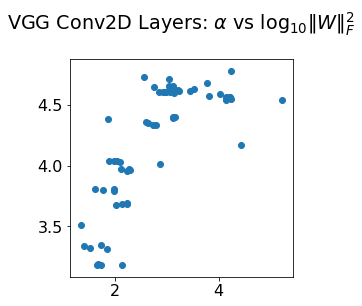

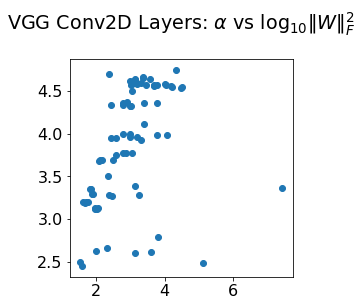

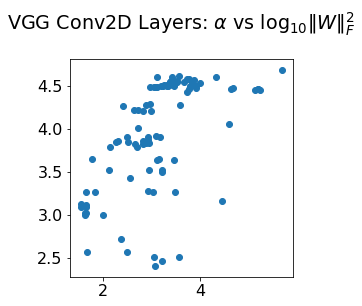

In [19]:
for model_name in alphas.keys():
    x = alphas[model_name]
    y =  2.0*np.log10(norms[model_name]) 
    plt.scatter(x,y,label=model_name )

    plt.title(r"VGG Conv2D Layers: $\alpha$ vs $\log_{10}\Vert W\Vert^{2}_{F}$"+"\n")
    #plt.ylim(0,20)
    plt.show()
#plt.legend()

[ 5.929604 +0.j  4.6931195+0.j  5.971523 +0.j  4.520993 +0.j
  3.7068458+0.j  5.152868 +0.j  5.6546535+0.j  4.508826 +0.j
  5.8888655+0.j  5.864708 +0.j  5.811292 +0.j  5.654266 +0.j
  5.931505 +0.j  4.5487785+0.j  6.205372 +0.j  6.146463 +0.j
  5.8557544+0.j  5.7229996+0.j 22.680511 +0.j 14.188918 +0.j
 21.368351 +0.j 16.43204  +0.j  8.095457 +0.j 15.961493 +0.j
 29.2464   +0.j 15.5990715+0.j 26.343027 +0.j  7.122927 +0.j
  6.8792253+0.j  7.0196824+0.j  6.592838 +0.j  5.5063   +0.j
  6.379893 +0.j  7.5649467+0.j  7.083263 +0.j  7.529225 +0.j
  8.285846 +0.j  7.3490825+0.j  8.735851 +0.j  7.491218 +0.j
  5.8857427+0.j  7.726602 +0.j  8.777016 +0.j  7.4794483+0.j
  8.888229 +0.j  7.9346733+0.j  7.5858073+0.j  7.7440257+0.j
  7.8949723+0.j  6.1741796+0.j  7.913988 +0.j  8.660063 +0.j
  8.261002 +0.j  8.50092  +0.j  9.261727 +0.j  4.895664 +0.j
  8.321861 +0.j  5.8720655+0.j  3.5274198+0.j  8.208531 +0.j
  8.39288  +0.j  6.869202 +0.j  8.326038 +0.j]


/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


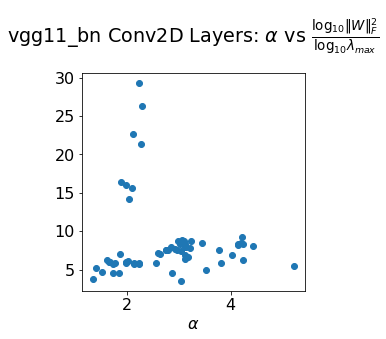

[26.999765 +0.j  8.63951  +0.j 40.07446  +0.j 12.935834 +0.j
  6.343679 +0.j  9.757742 +0.j 10.38117  +0.j 94.15326  +0.j
  4.083693 +0.j  4.4038105+0.j  4.400308 +0.j  5.0933814+0.j
  4.4070215+0.j  4.7217836+0.j  4.7724915+0.j  5.0028596+0.j
  4.400046 +0.j 31.55798  +0.j 21.63236  +0.j 38.642826 +0.j
 24.111395 +0.j 11.008227 +0.j 16.212646 +0.j 28.368654 +0.j
 20.369219 +0.j 25.53473  +0.j  9.2299595+0.j  6.5657864+0.j
  9.986277 +0.j  6.3942847+0.j  5.6218057+0.j  6.089336 +0.j
  9.114944 +0.j  6.7018228+0.j  8.614622 +0.j 16.555817 +0.j
 16.313128 +0.j 19.120626 +0.j 17.58926  +0.j  7.9236703+0.j
 17.004587 +0.j 19.832993 +0.j 18.091106 +0.j 22.393139 +0.j
  7.5819683+0.j  7.740692 +0.j  7.7835355+0.j  7.0996566+0.j
  6.226126 +0.j  7.176657 +0.j  8.493855 +0.j  7.942962 +0.j
  8.524557 +0.j  8.7949095+0.j  7.6420197+0.j  8.73871  +0.j
  7.9238725+0.j  6.054393 +0.j  7.846961 +0.j  8.826902 +0.j
  7.546766 +0.j  8.890681 +0.j  8.205861 +0.j  8.039214 +0.j
  8.028315 +0.j  8.26366

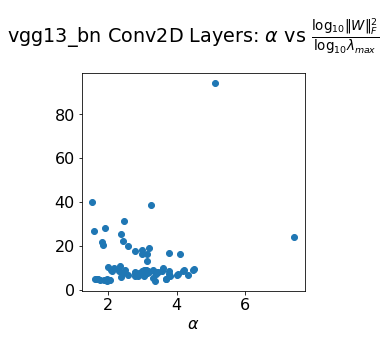

[  90.9553   +0.j    8.92251  +0.j   18.936579 +0.j   12.00307  +0.j
    5.556061 +0.j    8.989115 +0.j    9.976247 +0.j    4.9567256+0.j
    5.060269 +0.j    5.2233777+0.j    5.801559 +0.j    4.5106144+0.j
    5.1466517+0.j    5.4149237+0.j    5.234576 +0.j    4.868527 +0.j
   45.79294  +0.j   33.630733 +0.j   16.501362 +0.j   35.279865 +0.j
   45.209614 +0.j  278.75433  +0.j   13.1891165+0.j    9.81904  +0.j
   13.342287 +0.j    9.864887 +0.j    6.3683043+0.j    8.967791 +0.j
   14.185524 +0.j    8.566534 +0.j   11.655867 +0.j  219.0846   +0.j
   32.22936  +0.j 2804.1206   +0.j   22.595789 +0.j    7.6592684+0.j
   25.595993 +0.j   29.416492 +0.j   71.07337  +0.j   29.27272  +0.j
   69.051254 +0.j   41.316757 +0.j   11.1143875+0.j   26.25171  +0.j
  218.47015  +0.j   49.1719   +0.j   67.66546  +0.j   11.245664 +0.j
    9.966351 +0.j   11.492646 +0.j    9.008379 +0.j    8.068989 +0.j
    8.856658 +0.j   11.552903 +0.j   10.024817 +0.j   11.631588 +0.j
   14.7395935+0.j   13.4477   +0.j

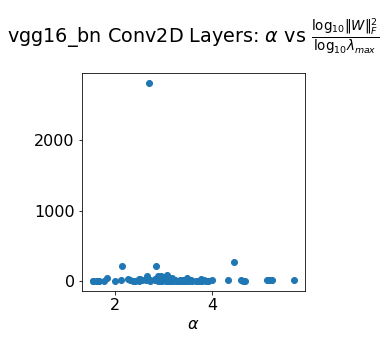

In [20]:
for model_name in alphas.keys():
    x = alphas[model_name]
    y = np.divide( 2.0*np.log10(norms[model_name]) , np.log10(lmaxs[model_name]) )
    print(y)
    plt.scatter(x,y,label=model_name )

    plt.title(model_name+r" Conv2D Layers: $\alpha$ vs $\frac{\log_{10}\Vert W\Vert^{2}_{F}}{\log_{10}\lambda_{max}}$"+"\n")
    plt.xlabel(r"$\alpha$")
    plt.show()
#plt.legend()

/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


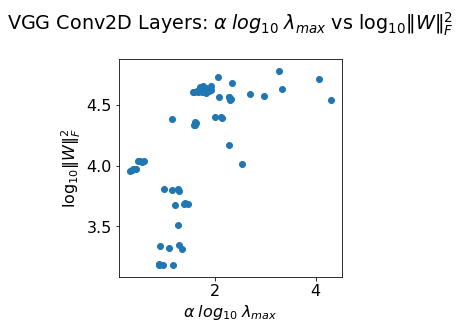

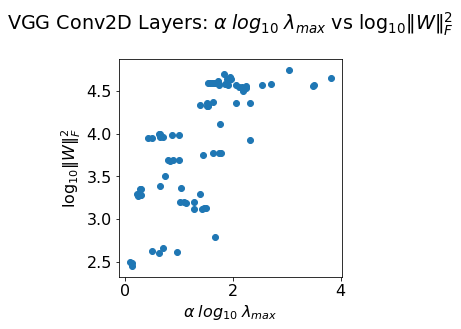

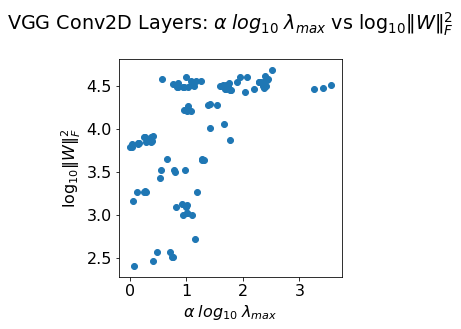

In [21]:
for model_name in alphas.keys():
    x =  np.multiply(alphas[model_name], np.log10(lmaxs[model_name]) )
    y =  2.0*np.log10(norms[model_name]) 
    plt.scatter(x,y,label=model_name )

    plt.title(r"VGG Conv2D Layers: $\alpha\;log_{10}\;\lambda_{max}$ vs $\log_{10}\Vert W\Vert^{2}_{F}$"+"\n")
    #plt.ylim(0,20)
    plt.xlabel(r"$\alpha\;log_{10}\;\lambda_{max}$")
    plt.ylabel(r"$\log_{10}\Vert W\Vert^{2}_{F}$")

    plt.show()

### Randomize Matrices

In [22]:
def rand_model_alphas(model):
    try:
        alphas, norms, lmaxs = [], [], []

        for W in tqdm(iter_pytotch_layers(model)):
            M, N = W.shape[0], W.shape[1]
            print(M,N)
            if M > 1024:
                break
                
           # correct for glorot normalization
            glorot_correction = np.sqrt(np.average(W.shape))
            W = W*glorot_correction
            
            # shuffle W
            W = W.ravel()
            np.random.shuffle(W)
            W = W.reshape(N,M)
            
            normW = np.linalg.norm(W)

            if (M>N):
                X=np.dot(W.T,W)/N
            else:
                X=np.dot(W,W.T)/N

            evals = np.linalg.eigvals(X)
            
            l_max = np.max(evals)
            #if (l_max > 1):

            fit = powerlaw.Fit(evals, xmax=l_max, verbose=False)


            print(N, M, X.shape, fit.alpha, np.max(evals), fit.D)

            alphas.append(fit.alpha)
            norms.append(normW)
            lmaxs.append(l_max)
            
           
    except Exception as e: 

        print("skipping ", model_name)
        print(e)

        pass
    
    return  np.array(alphas),  np.array(norms), np.array(lmaxs)

In [26]:
model_name = 'vgg11'
model = models.vgg11(pretrained=True)
alphas[model_name], norms[model_name], lmaxs[model_name] =  calc_model_alphas(model)

128 64
64 128 (64, 64) 1.6501380557141414 6.738295 0.1694855053362465
128 64
64 128 (64, 64) 1.5729749512187854 8.271922 0.1797384350918581
128 64


/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


64 128 (64, 64) 1.4121035942309466 6.4598393 0.19428117596452105
128 64
64 128 (64, 64) 1.4345913109436141 6.8347855 0.18133933322787987
128 64
64 128 (64, 64) 1.6184989159677603 13.821855 0.16232586138055982
128 64
64 128 (64, 64) 1.3854852949105274 8.080619 0.18905146934229966
128 64
64 128 (64, 64) 1.569204110777663 5.6521955 0.1819836181454877
128 64
64 128 (64, 64) 1.4466121577534141 7.4524913 0.18158004314008436
128 64
64 128 (64, 64) 1.6136188055006313 6.271439 0.17297128682994922
256 128
128 256 (128, 128) 2.6822107696456925 3.8933222 0.15839166995063148
256 128
128 256 (128, 128) 1.6245755183676356 6.0587945 0.15038343403592247
256 128
128 256 (128, 128) 1.7481681533160724 3.8148115 0.15976226159856022
256 128
128 256 (128, 128) 2.576076637045816 6.5674796 0.13313312865838484
256 128
128 256 (128, 128) 2.53372629580107 11.5017805 0.1260402015887302
256 128
128 256 (128, 128) 1.615083227571029 6.9235363 0.12912552961625856
256 128
128 256 (128, 128) 1.6649286743131322 3.616818 

/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:1160: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


256 256 (256, 256) 2.025263614368387 3.2093854 0.12252819152531846
256 256
256 256 (256, 256) 2.048447913043735 2.502136 0.12204158382166175
256 256
256 256 (256, 256) 2.658269352938596 3.1404648 0.12169916242995937
256 256
256 256 (256, 256) 1.80045362839399 5.752889 0.11590080291933835
256 256
256 256 (256, 256) 2.042517458656814 3.498113 0.12374506755489251
256 256
256 256 (256, 256) 2.6040953714076167 2.5047364 0.1242841322676077
256 256
256 256 (256, 256) 1.9744266107780324 3.1301105 0.12141228533720927
256 256
256 256 (256, 256) 2.073195547557657 2.4406357 0.1321530823826083
512 256
256 512 (256, 256) 2.651723173693334 4.4681783 0.10811342580002525
512 256
256 512 (256, 256) 2.1681144770246012 5.461192 0.1237198549105295
512 256
256 512 (256, 256) 2.689082947115983 4.4894295 0.09975517998639649
512 256
256 512 (256, 256) 2.055719116616769 6.160263 0.11025216122298409
512 256
256 512 (256, 256) 3.8241504066156065 10.704096 0.09906479789549272
512 256
256 512 (256, 256) 2.841661182

In [23]:
model_name = 'vgg11_rand'
model = models.vgg11(pretrained=True)
alphas[model_name], norms[model_name], lmaxs[model_name] =  rand_model_alphas(model)


128 64


/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:1160: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


64 128 (128, 128) 7.756473592254887 2.4535956 0.1428571428571429
128 64
64 128 (128, 128) 4.307803256364158 2.7390742 0.17153555112925323
128 64
64 128 (128, 128) 4.822964533329058 2.1914363 0.22965892997587334
128 64
64 128 (128, 128) 8.299037341947251 2.4144707 0.19319476287718818
128 64
64 128 (128, 128) 4.782448516106395 3.9188702 0.17628420101788322
128 64
64 128 (128, 128) 2.6083043174831952 2.3716648 0.24405642100699965
128 64
64 128 (128, 128) 3.132519855856731 1.7861769 0.24647451486147803
128 64
64 128 (128, 128) 3.211975973368001 2.4288952 0.22596577280877378
128 64
64 128 (128, 128) 4.619610862492857 2.2937303 0.22101939512545465
256 128
128 256 (256, 256) 6.2874098593766865 1.1858569 0.20059196356126818
256 128
128 256 (256, 256) 6.855002473465418 1.8032168 0.15677590524568097
256 128
128 256 (256, 256) 3.166687935026117 1.1480997 0.22462421886522466
256 128
128 256 (256, 256) 4.132931890466837 1.6028677 0.21414895468028883
256 128
128 256 (256, 256) 9.272392345221945 3.33

Text(0,0.5,'$\\log_{10}\\Vert W\\Vert^{2}_{F}$')

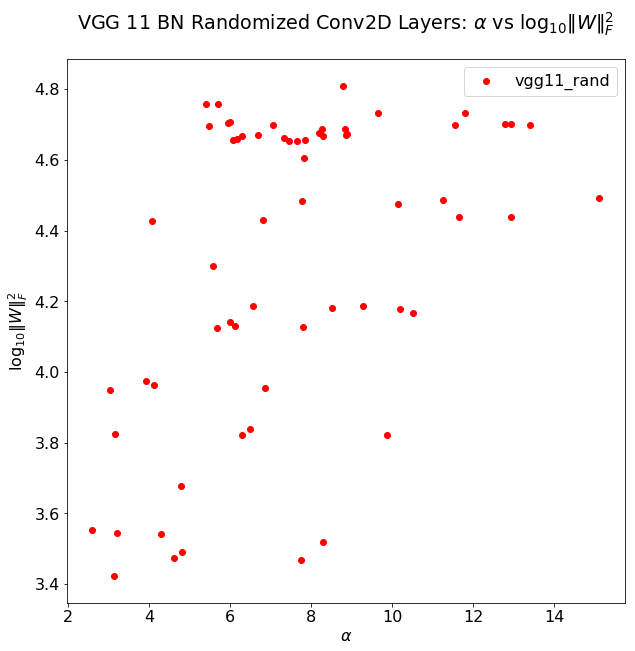

In [27]:
plt.rcParams['figure.figsize'] = [10,10]
matplotlib.rcParams.update({'font.size': 16})

model_name = 'vgg11_rand'
x = alphas[model_name]
y =  2.0*np.log10(norms[model_name]) 
plt.scatter(x,y,label=model_name , color='red')

model_name = 'vgg11'
x = alphas[model_name]
y =  2.0*np.log10(norms[model_name]) 
#plt.scatter(x,y,label=model_name, color='blue' )


plt.title(r"VGG 11 BN Randomized Conv2D Layers:"+r" $\alpha$ vs $\log_{10}\Vert W\Vert^{2}_{F}$"+"\n")
plt.legend()
plt.xlabel(r"$\alpha}$")
plt.ylabel(r"$\log_{10}\Vert W\Vert^{2}_{F}$")

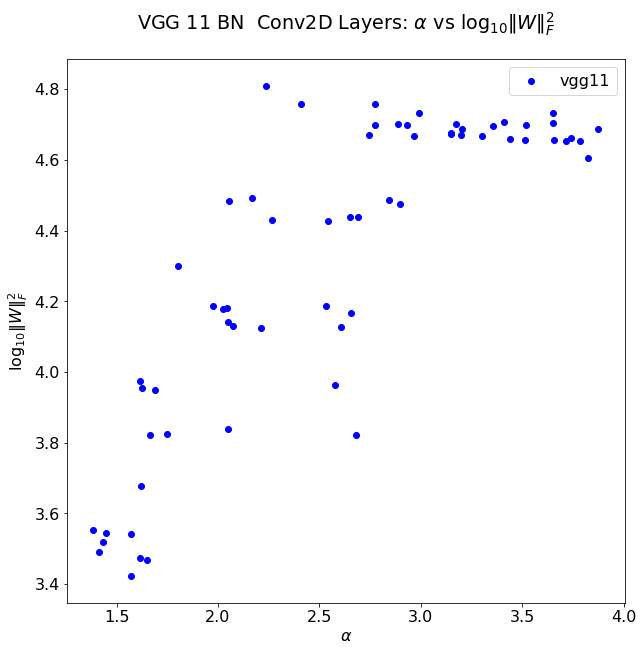

In [28]:
plt.rcParams['figure.figsize'] = [10,10]
matplotlib.rcParams.update({'font.size': 16})


model_name = 'vgg11'
x = alphas[model_name]
y =  2.0*np.log10(norms[model_name]) 
plt.scatter(x,y,label=model_name, color='blue' )


plt.title(r"VGG 11 BN  Conv2D Layers:"+r" $\alpha$ vs $\log_{10}\Vert W\Vert^{2}_{F}$"+"\n")
plt.legend()
plt.xlabel(r"$\alpha}$")
plt.ylabel(r"$\log_{10}\Vert W\Vert^{2}_{F}$")

plt.savefig("img/fro-vgg11.png")

Text(0,0.5,'$\\lambda^{rand}_{max}$')

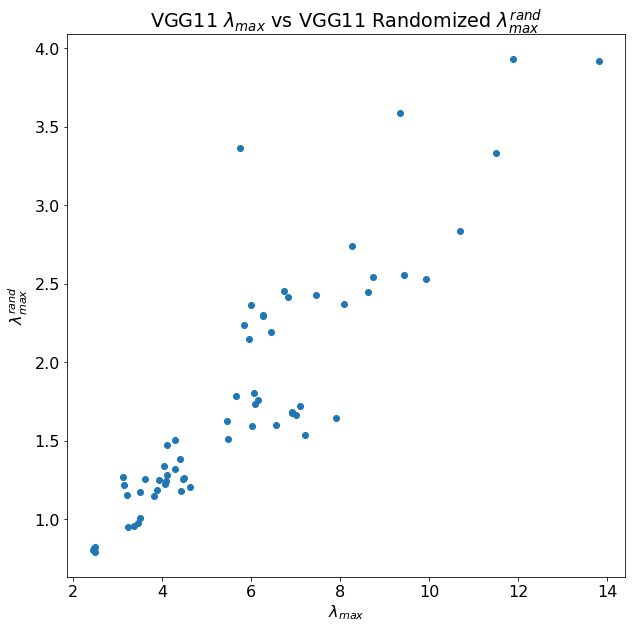

In [29]:

model_name = 'vgg11'
x = lmaxs[model_name]

model_name = 'vgg11_rand'
y = lmaxs[model_name]


plt.title(r"VGG11 $\lambda_{max}$ vs VGG11 Randomized $\lambda^{rand}_{max}$")
plt.scatter(x,y, label='VGG 11' )

plt.xlabel(r"$\lambda_{max}$")
plt.ylabel(r"$\lambda^{rand}_{max}$")
#plt.legend()


Text(0,0.5,'$\\alpha^{rand}')

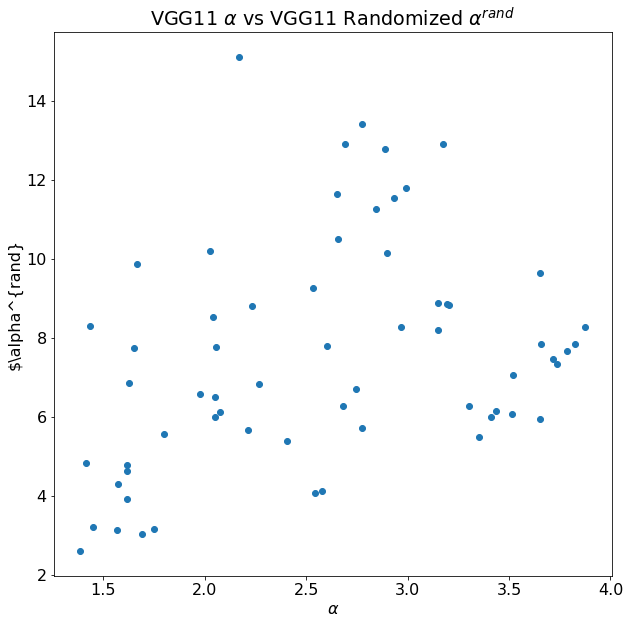

In [30]:

model_name = 'vgg11'
x = alphas[model_name]

model_name = 'vgg11_rand'
y = alphas[model_name]


plt.title(r"VGG11 $\alpha$ vs VGG11 Randomized $\alpha^{rand}$")
plt.scatter(x,y, label='VGG 11' )

plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\alpha^{rand}")
#plt.legend()


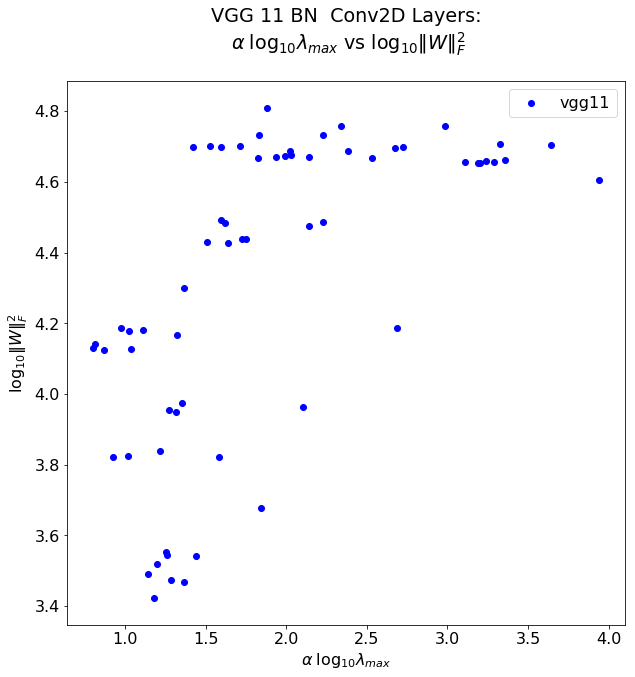

In [35]:
plt.rcParams['figure.figsize'] = [10,10]
matplotlib.rcParams.update({'font.size': 16})


model_name = 'vgg11'
x = np.multiply(alphas[model_name], np.log10(lmaxs[model_name]) )
y =  2.0*np.log10(norms[model_name]) 
plt.scatter(x,y,label=model_name, color='blue' )


plt.title("VGG 11 BN  Conv2D Layers:\n"+r" $\alpha\;\log_{10}\lambda_{max}$ vs $\log_{10}\Vert W\Vert^{2}_{F}$"+"\n")
plt.legend()
plt.xlabel(r"$\alpha\;\log_{10}\lambda_{max}$")
plt.ylabel(r"$\log_{10}\Vert W\Vert^{2}_{F}$")

plt.savefig("img/relation-vgg11.png")